In [1]:
# !python train.py --config ./config/test_nyu_laptop_mixloss.yaml --output_dir ./test_files --base_data_dir C:/Users/micha/Downloads/nyu_v2-20240826T235024Z-001
# !python train.py --config ./config/test_nyu_laptop_lienear.yaml  --output_dir ./test_files --base_data_dir C:/Users/micha/Downloads/nyu_v2-20240826T235024Z-001
# !python train.py --resume_run ./test_files/24_09_04-08_16_27-test_nyu_laptop_norm/checkpoint/latest  --output_dir ./test_files --base_data_dir C:/Users/micha/Downloads/nyu_v2-20240826T235024Z-001
# !python train.py --config ./config/test_nyu_laptop_disp.yaml  --output_dir ./test_files --base_data_dir C:/Users/micha/Downloads/nyu_v2-20240826T235024Z-001
!python train.py --config ./config/test_nyu_laptop_mixloss_disp.yaml  --output_dir ./test_files --base_data_dir C:/Users/micha/Downloads/nyu_v2-20240826T235024Z-001

start at 2024-09-04 11:31:20.242314
 2024-09-04 11:31:20,293 - INFO -train.py - <module> >> device = cuda
 2024-09-04 11:31:20,305 - INFO -train.py - <module> >> Config saved to ./test_files\24_09_04-11_31_20-test_nyu_laptop_mixloss_disp\config.yaml
 2024-09-04 11:31:20,405 - INFO -train.py - <module> >> Code snapshot saved to: ./test_files\24_09_04-11_31_20-test_nyu_laptop_mixloss_disp\code_snapshot.tar
 2024-09-04 11:31:36,623 - INFO -mytrainer.py - train >> Start training
 2024-09-04 11:41:16,152 - INFO -mytrainer.py - validate >> Iter 140. Validation metrics on `nyu_v2`: abs_relative_difference: 0.058 | squared_relative_difference: 0.097 | rmse_linear: 0.161 | rmse_log: 0.056 | log10: 0.021 | delta1_acc: 0.047 | delta2_acc: 0.084 | delta3_acc: 0.106 | i_rmse: 0.133 | silog_rmse: 4.423 | loss: 0.117
 2024-09-04 11:41:16,185 - INFO -mytrainer.py - validate >> Best metric: abs_relative_difference = 0.05757283367825754 at iteration 140
 2024-09-04 11:48:56,494 - INFO -mytrainer.py - va

'rsync' is not recognized as an internal or external command,
operable program or batch file.
tar: : Couldn't visit directory: No such file or directory
tar: Error exit delayed from previous errors.
'rm' is not recognized as an internal or external command,
operable program or batch file.
c:\Users\micha\anaconda3\envs\pytorch-env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\micha\anaconda3\envs\pytorch-env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)

  0%|          | 0/140 [00:00<?, ?it/s]c:\Users\mich

In [1]:
import argparse
import logging

import os
import shutil
from datetime import datetime, timedelta
from typing import List

import torch
from omegaconf import OmegaConf
from torch.utils.data import ConcatDataset, DataLoader
from tqdm import tqdm

from models.MiDas import MidasNet
from models.TernausNet import UNet16 

from datasets import BaseDepthDataset, DatasetMode, get_dataset
from datasets.mixed_sampler import MixedBatchSampler
from trainers.mytrainer import NetTrainer
from util.config_util import (
    find_value_in_omegaconf,
    recursive_load_config,
)
from util.depth_transform import (
    DepthNormalizerBase,
    get_depth_normalizer,
)
from util.logging_util import(
  config_logging
)
from util.alignment import depth2disparity, align_depth_least_square

c:\Users\micha\anaconda3\envs\pytorch-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
t_start = datetime.now()
print(f"start at {t_start}")
# -------------------- Arguments --------------------
class argumenty():
    def __init__(self) -> None:
        self.config = './config/test_nyu_laptop.yaml'
        self.resume_run = './test_files/24_09_04-02_27_19-test_nyu_laptop_mixloss/checkpoint/latest'
        self.output_dir = './test_files'
        self.no_cuda = False
        self.exit_after = -1
        self.base_data_dir = "C:/Users/micha/Downloads/nyu_v2-20240826T235024Z-001"
        self.add_datetime_prefix = True
        
args = argumenty()
resume_run = args.resume_run
output_dir = args.output_dir
base_data_dir = (
    args.base_data_dir
    if args.base_data_dir is not None
    else os.environ["BASE_DATA_DIR"]
)
# -------------------- Initialization --------------------
# Resume previous run
if resume_run is not None:
    print(f"Resume run: {resume_run}")
    out_dir_run = os.path.dirname(os.path.dirname(resume_run))
    job_name = os.path.basename(out_dir_run)
    # Resume config file
    cfg = OmegaConf.load(os.path.join(out_dir_run, "config.yaml"))
else:
    # Run from start
    cfg = recursive_load_config(args.config)
    # Full job name
    pure_job_name = os.path.basename(args.config).split(".")[0]
    # Add time prefix
    if args.add_datetime_prefix:
        job_name = f"{t_start.strftime('%y_%m_%d-%H_%M_%S')}-{pure_job_name}"
    else:
        job_name = pure_job_name
    # Output dir
    if output_dir is not None:
        out_dir_run = os.path.join(output_dir, job_name)
    else:
        out_dir_run = os.path.join("./output", job_name)
    os.makedirs(out_dir_run, exist_ok=False)
# Other directories
out_dir_ckpt = os.path.join(out_dir_run, "checkpoint")
if not os.path.exists(out_dir_ckpt):
    os.makedirs(out_dir_ckpt)
out_dir_tr = os.path.join(out_dir_run, "training_record")
if not os.path.exists(out_dir_tr):
    os.makedirs(out_dir_tr)
out_dir_eval = os.path.join(out_dir_run, "evaluation_record")
if not os.path.exists(out_dir_eval):
    os.makedirs(out_dir_eval)
# -------------------- Logging settings --------------------
config_logging(cfg.logging, out_dir=out_dir_run)
logging.debug(f"config: {cfg}")
# -------------------- Device --------------------
cuda_avail = torch.cuda.is_available() and not args.no_cuda
device = torch.device("cuda" if cuda_avail else "cpu")
logging.info(f"device = {device}")
# -------------------- Snapshot of code and config --------------------
if resume_run is None:
    _output_path = os.path.join(out_dir_run, "config.yaml")
    with open(_output_path, "w+") as f:
        OmegaConf.save(config=cfg, f=f)
    logging.info(f"Config saved to {_output_path}")
    # Copy and tar code on the first run
    _temp_code_dir = os.path.join(out_dir_run, "code_tar")
    _code_snapshot_path = os.path.join(out_dir_run, "code_snapshot.tar")
    os.system(
        f"rsync --relative -arhvz --quiet --filter=':- .gitignore' --exclude '.git' . '{_temp_code_dir}'"
    )
    os.system(f"tar -cf {_code_snapshot_path} {_temp_code_dir}")
    os.system(f"rm -rf {_temp_code_dir}")
    logging.info(f"Code snapshot saved to: {_code_snapshot_path}")
# -------------------- Data --------------------
loader_seed = cfg.dataloader.seed
if loader_seed is None:
    loader_generator = None
else:
    loader_generator = torch.Generator().manual_seed(loader_seed)
# Training dataset
depth_transform: DepthNormalizerBase = get_depth_normalizer(
    cfg_normalizer=cfg.depth_normalization
)
train_dataset: BaseDepthDataset = get_dataset(
    cfg.dataset.train,
    base_data_dir=base_data_dir,
    mode=DatasetMode.TRAIN,
    augmentation_args=cfg.augmentation_args,
    depth_transform=depth_transform,
    gt_depth_type=cfg.gt_depth_type
)
logging.debug("Augmentation: ", cfg.augmentation_args)
if "mixed" == cfg.dataset.train.name:
    dataset_ls = train_dataset
    assert len(cfg.dataset.train.prob_ls) == len(
        dataset_ls
    ), "Lengths don't match: `prob_ls` and `dataset_list`"
    concat_dataset = ConcatDataset(dataset_ls)
    mixed_sampler = MixedBatchSampler(
        src_dataset_ls=dataset_ls,
        batch_size=cfg.dataloader.train_batch_size,
        drop_last=True,
        prob=cfg.dataset.train.prob_ls,
        shuffle=True,
        generator=loader_generator,
    )
    train_loader = DataLoader(
        concat_dataset,
        batch_sampler=mixed_sampler,
        num_workers=cfg.dataloader.num_workers,
        pin_memory=cfg.dataloader.pin_memory, 
    )
else:
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=cfg.dataloader.train_batch_size,
        num_workers=cfg.dataloader.num_workers,
        shuffle=True,
        generator=loader_generator,
        pin_memory=cfg.dataloader.pin_memory,
    )
# Validation dataset
val_dataset: BaseDepthDataset = get_dataset(
    cfg.dataset.val,
    base_data_dir=base_data_dir,
    mode=DatasetMode.TRAIN,
    depth_transform=depth_transform,
    gt_depth_type=cfg.gt_depth_type
)
if "mixed" == cfg.dataset.val.name:
    dataset_ls = val_dataset
    assert len(cfg.dataset.val.prob_ls) == len(
        dataset_ls
    ), "Lengths don't match: `prob_ls` and `dataset_list`"
    concat_dataset = ConcatDataset(dataset_ls)
    mixed_sampler = MixedBatchSampler(
        src_dataset_ls=dataset_ls,
        batch_size=cfg.dataloader.val_batch_size,
        drop_last=True,
        prob=cfg.dataset.val.prob_ls,
        shuffle=False,
        generator=loader_generator,
    )
    val_loader = DataLoader(
        concat_dataset,
        batch_sampler=mixed_sampler,
        num_workers=cfg.dataloader.num_workers,
        pin_memory=cfg.dataloader.pin_memory,
    )
else:
    val_loader = DataLoader(
        dataset=val_dataset,
        batch_size=cfg.dataloader.val_batch_size,
        num_workers=cfg.dataloader.num_workers,
        shuffle=False,
        generator=loader_generator,
        pin_memory=cfg.dataloader.pin_memory,
    )
# Test dataset
test_loaders: List[DataLoader] = []
for _test_dic in cfg.dataset.test:
    _test_dataset = get_dataset(
        _test_dic,
        base_data_dir=base_data_dir,
        mode=DatasetMode.TRAIN,
        depth_transform=depth_transform,
        gt_depth_type=cfg.gt_depth_type
    )
    _test_loader = DataLoader(
        dataset=_test_dataset,
        batch_size=cfg.dataloader.test_batch_size,
        shuffle=False,
        num_workers=cfg.dataloader.num_workers,
        pin_memory=cfg.dataloader.pin_memory,
    )
    test_loaders.append(_test_loader)
# -------------------- Model --------------------
if cfg.model.name == 'TernausNet':
    model = UNet16(pretrained=True, is_deconv=True)
elif cfg.model.name == 'MiDas':
  model = MidasNet(backbone=cfg.model.backbone)
else:
  raise NotImplementedError 
# -------------------- Trainer --------------------
# Exit time
if args.exit_after > 0:
    t_end = t_start + timedelta(minutes=args.exit_after)
    logging.info(f"Will exit at {t_end}")
else:
    t_end = None
logging.debug(f"Trainer: treiner_nets")
trainer = NetTrainer(
    cfg=cfg,
    model=model,
    train_dataloader=train_loader,
    device=device,
    out_dir_ckpt=out_dir_ckpt,
    out_dir_tr=out_dir_tr,
    out_dir_eval=out_dir_eval,
    val_dataloader=val_loader,
    test_dataloaders=test_loaders,
)
# -------------------- Checkpoint --------------------
if resume_run is not None:
    trainer.load_checkpoint(
        resume_run, load_trainer_state=True, resume_lr_scheduler=True
    )
# -------------------- Training & Evaluation Loop --------------------
# try:
#     trainer.train(t_end=t_end)
# except Exception as e:
#     logging.exception(e)

start at 2024-09-04 13:58:39.794043
Resume run: ./test_files/24_09_04-02_27_19-test_nyu_laptop_mixloss/checkpoint/latest
 2024-09-04 13:58:40,123 - INFO -3554256549.py - <module> >> device = cuda


c:\Users\micha\anaconda3\envs\pytorch-env\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\micha\anaconda3\envs\pytorch-env\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


 2024-09-04 13:58:47,160 - INFO -mytrainer.py - load_checkpoint >> Loading checkpoint from: ./test_files/24_09_04-02_27_19-test_nyu_laptop_mixloss/checkpoint/latest
 2024-09-04 13:58:48,856 - INFO -mytrainer.py - load_checkpoint >> Net parameters are loaded from ./test_files/24_09_04-02_27_19-test_nyu_laptop_mixloss/checkpoint/latest\net.pth
 2024-09-04 13:58:48,879 - INFO -mytrainer.py - load_checkpoint >> optimizer state is loaded from ./test_files/24_09_04-02_27_19-test_nyu_laptop_mixloss/checkpoint/latest
 2024-09-04 13:58:48,881 - INFO -mytrainer.py - load_checkpoint >> LR scheduler state is loaded from ./test_files/24_09_04-02_27_19-test_nyu_laptop_mixloss/checkpoint/latest
 2024-09-04 13:58:48,941 - INFO -mytrainer.py - load_checkpoint >> Checkpoint loaded from: ./test_files/24_09_04-02_27_19-test_nyu_laptop_mixloss/checkpoint/latest. Resume from iteration 1400 (epoch 10)


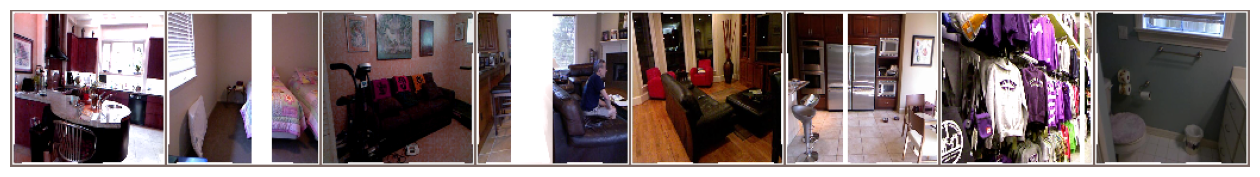

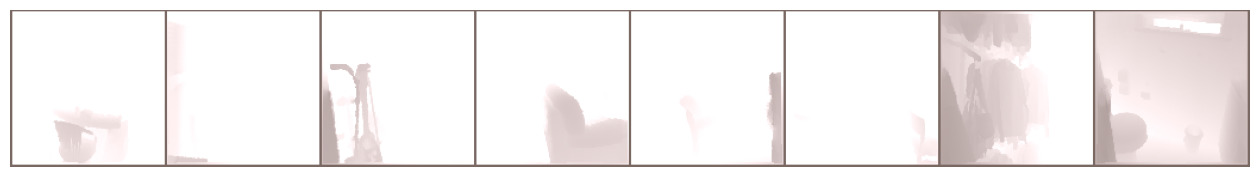

 2024-09-04 14:01:17,053 - WARNING -image.py - _normalize_image_array >> Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


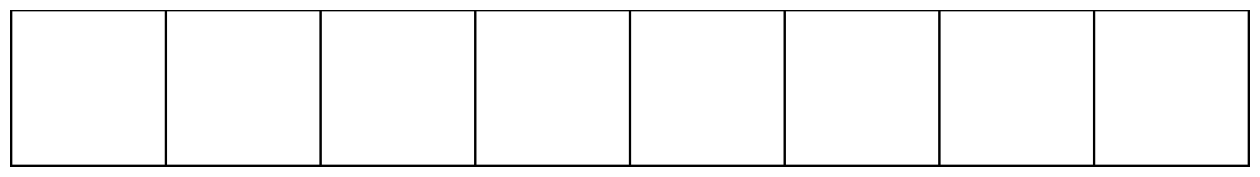

 2024-09-04 14:01:17,261 - WARNING -image.py - _normalize_image_array >> Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


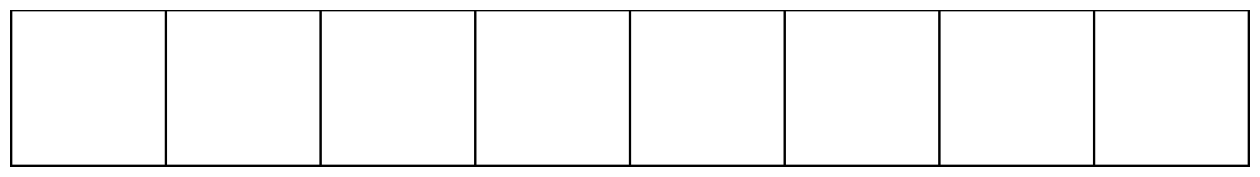

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

def imgshow(inp, title=None, pred=False):
    inp = inp.numpy().transpose((1, 2, 0))
    if not pred:
        mean = np.array([0.48012177, 0.41071795, 0.39187136])
        std = np.array([0.28875302, 0.29516797, 0.30792887])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
    plt.axis("off")
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
batch = next(iter(train_loader))
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(batch['rgb_img'])
imgshow(grid_imgs)
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(batch['depth_raw_linear'])
imgshow(grid_imgs)

pred_samples = trainer.model(batch['rgb_img'].to(device))
pred_samples_a = align_depth_least_square(batch['depth_raw_linear'], pred_samples.detach().cpu(), batch['valid_mask_raw'], return_scale_shift=False)
plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(pred_samples.cpu())
imgshow(grid_imgs, pred=True)

plt.figure(figsize=(16,24))
grid_imgs = torchvision.utils.make_grid(pred_samples_a)
imgshow(grid_imgs, pred=True)

torch.cuda.empty_cache()

In [18]:
import glob
glob.glob('./test_files/*test_nyu_laptop*/*/train*.csv')

['./test_files\\24_09_04-02_27_19-test_nyu_laptop_mixloss\\training_record\\train_record.csv',
 './test_files\\24_09_04-06_35_12-test_nyu_laptop_lienear\\training_record\\train_record.csv',
 './test_files\\24_09_04-08_16_27-test_nyu_laptop_norm\\training_record\\train_record.csv',
 './test_files\\24_09_04-09_42_56-test_nyu_laptop_disp\\training_record\\train_record.csv',
 './test_files\\24_09_04-11_31_20-test_nyu_laptop_mixloss_disp\\training_record\\train_record.csv']

In [31]:
tr_list[i].split('\\')[-3].split('_')[7:]

['mixloss', 'disp']

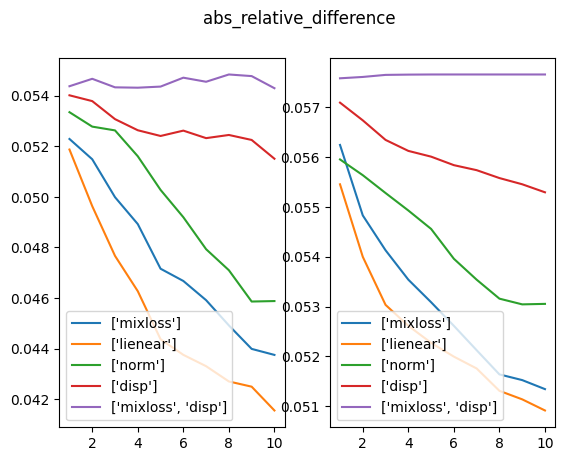

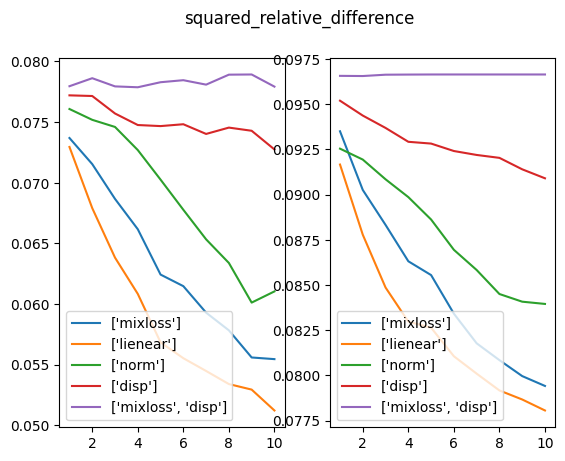

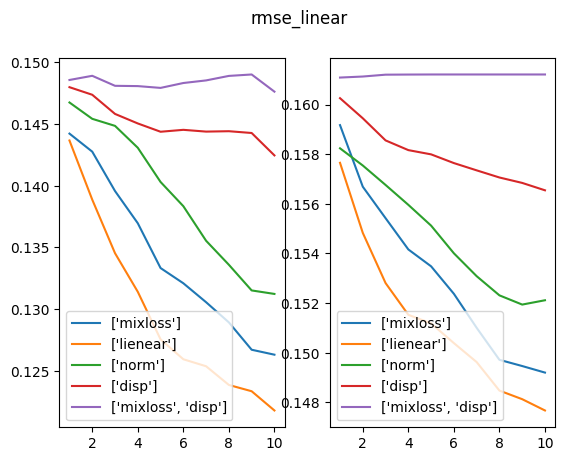

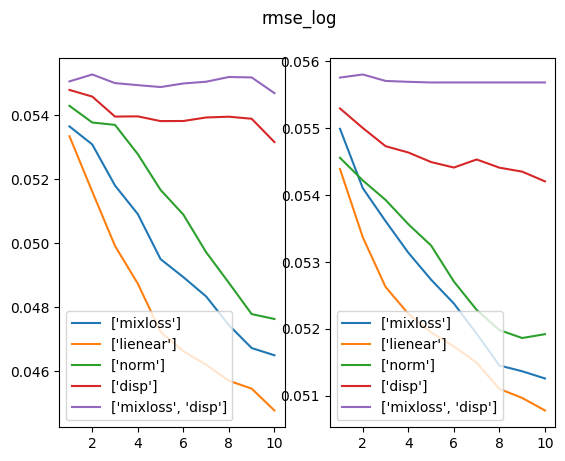

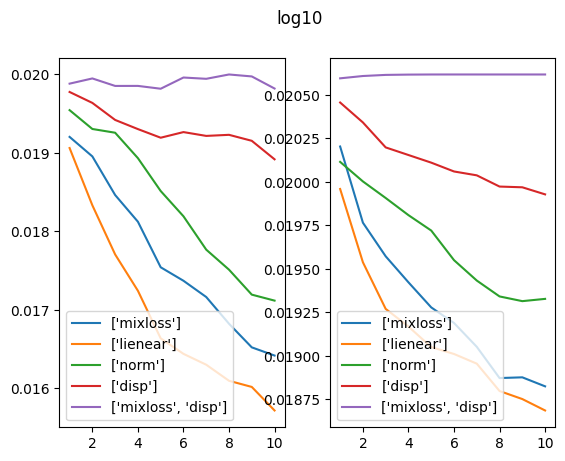

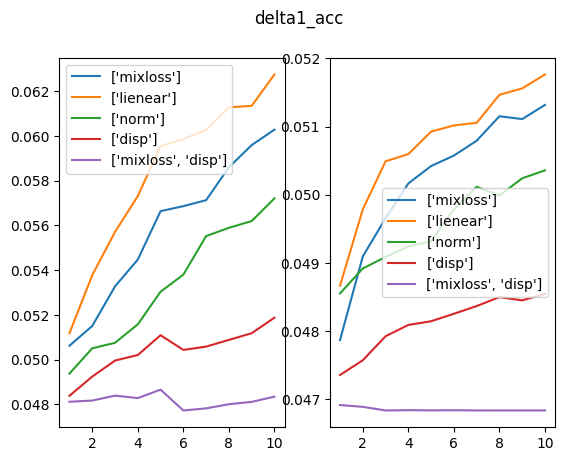

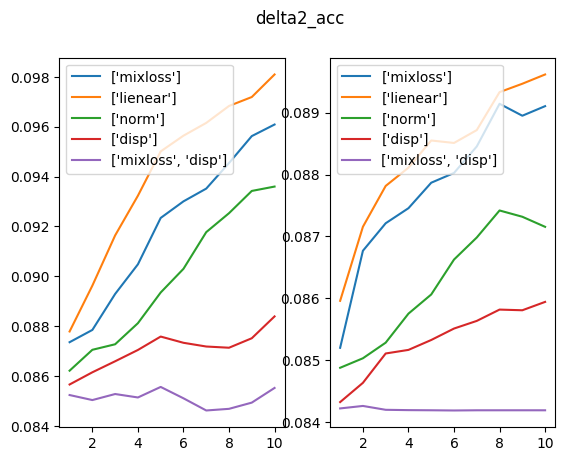

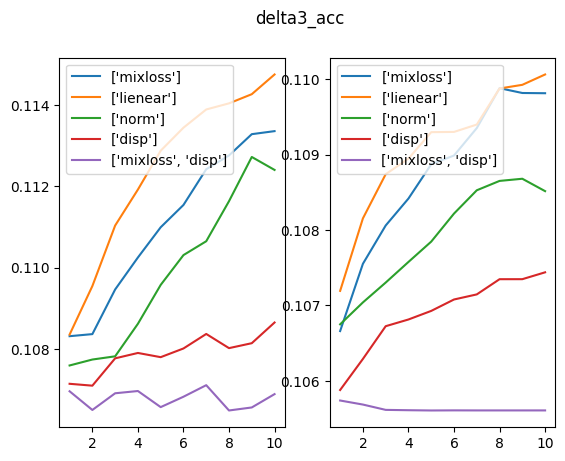

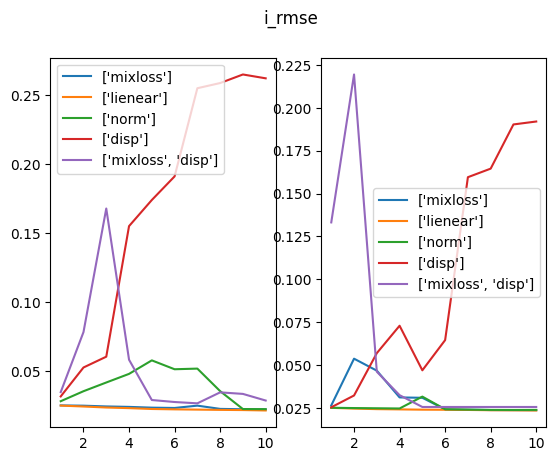

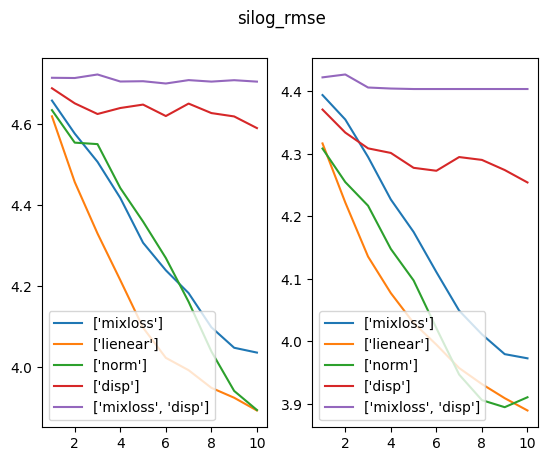

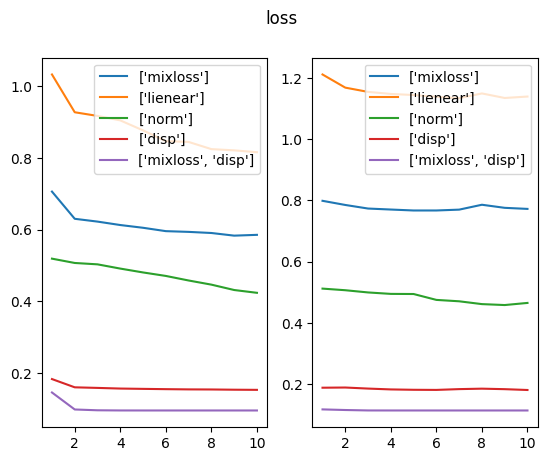

In [32]:
import matplotlib.pyplot as plt
import pandas as pd
import glob

tr_list = glob.glob('../test_files/*test_nyu_laptop*/*/train*.csv')
vl_list = glob.glob('../test_files/*test_nyu_laptop*/*/eval*.csv')


tr0 = pd.read_csv(tr_list[0])


for name in tr0.columns[1:]:
    f, (a1,a2) = plt.subplots(1,2)
    f.suptitle(name)
    for i in range(len(tr_list)):
        tr = pd.read_csv(tr_list[i])
        vl = pd.read_csv(vl_list[i])
        a1.plot(tr['epoch'], tr[name], label = tr_list[i].split('\\')[-3].split('_')[7:])
        a2.plot(vl['epoch'], vl[name], label = vl_list[i].split('\\')[-3].split('_')[7:])
        a1.legend()
        a2.legend()
    plt.show()